In [1]:
from google.colab import auth
from google.oauth2 import service_account
from googleapiclient.discovery import build

auth.authenticate_user()

In [2]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd

scope = ['https://www.googleapis.com/auth/spreadsheets']
creds = ServiceAccountCredentials.from_json_keyfile_name('credentials.json', scope)

client = gspread.authorize(creds)

spreadsheet_url = 'https://docs.google.com/spreadsheets/d/1CatLlB4axdBW0uJRoioR-x00RsPzQ54CFYq1PqzgV7E/edit?usp=drive_web&ouid=107190373735789167396'
sheet = client.open_by_url(spreadsheet_url)

worksheet = sheet.get_worksheet(0)
data = worksheet.get_all_records()
df_synthetic = pd.DataFrame(data)

df_synthetic.head()

,,NAME,id,GENDER,AGE,RACETHN,EDUCCAT5,DIVISION,MARITAL_ACS,HHSIZECAT,...,CI_LABEL_OWNGUN_GSS,CI_LABEL_SEXUALITY,CI_LABEL_HIV_STAT,CI_LABEL_PREG_STAT,CI_LABEL_CC_NUM,CI_LABEL_cc_encoded,CI_LABEL_cc_disclosed,CI_LABEL_NumChronicIllness,AGE_INT,Cluster
0,0,Luke Walsh,1,Male,25,White non-Hispanic,Some college,Mountain,Never married,3+,...,is,is,is probably,is probably,is,is probably,is possibly,is probably,20-29,5
1,1,Matilde Izaguirre Checa,2,Female,70,Hispanic,HS Grad,West South Central,Divorced,1,...,is probably,is possibly,is,is,is,is,is,is possibly,70-79,11
2,2,Ryan Smith,3,Male,85,White non-Hispanic,Less than HS,Middle Atlantic,Now married,2,...,is possibly,is probably,is probably,is,is probably,is probably,is probably,is probably,80-89,2
3,3,Matthew Grimes,4,Male,59,White non-Hispanic,HS Grad,Mountain,Now married,2,...,is probably,is probably,is probably,is,is possibly,is probably,is,is probably,50-59,12
4,4,Miraan Rama,5,Female,19,Asian,Some college,Pacific,Never married,1,...,is probably,is,is probably,is,is probably,is probably,is probably,is,10-19,9


In [6]:
import pandas as pd

# Load the data file (adjust file name and method if it's an Excel file)
df = pd.read_csv('prolific_responses_survey2.csv')

# Define the mapping from Likert-scale text to numbers
likert_mapping = {
    "Not at all harmful": 1,
    "Slightly harmful": 2,
    "Moderately harmful": 3,
    "Very harmful": 4,
    "Extremely harmful": 5
}

# List the columns that contain Likert-scale responses.
# Update this list to include all columns that need conversion.
likert_columns = ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"]

# Replace the text values with numeric values in those columns
for col in likert_columns:
    if col in df.columns:  # only replace if column exists in the dataframe
        df[col] = df[col].replace(likert_mapping)

/tmp/ipython-input-1004496578.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(likert_mapping)


In [7]:
import pandas as pd

# Assuming the DataFrame is called df and has columns:
# ["ProlificID", "SyntheticPersonID", "AttnCheck", "Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8", "Condition"]

# 1) Group by SyntheticPersonID and compute the mean for Q1..Q8
df_avg = (
    df.groupby("SyntheticPersonID")[["Q1","Q2","Q3","Q4","Q5","Q6","Q7","Q8", "Certainty"]]
      .mean()  # average across repeated rows for each SyntheticPersonID
      .reset_index()
)

# 2) (Optional) If expecting a single "avg_harm" column across Q1..Q8
df_avg["avg_harm"] = df_avg[["Q1","Q2","Q3","Q4","Q5","Q6","Q7","Q8"]].mean(axis=1)

print(df_avg.head())

   SyntheticPersonID        Q1   Q2        Q3        Q4        Q5   Q6  \
0                 57  3.000000  3.0  3.000000  2.500000  2.000000  2.5   
1                 89  2.500000  2.5  2.500000  2.500000  2.500000  2.5   
2                141  3.250000  2.0  2.750000  2.000000  1.500000  2.0   
3                153  4.333333  4.0  3.666667  3.666667  1.666667  2.0   
4                166  2.500000  3.5  3.500000  2.000000  2.000000  2.5   

         Q7        Q8  Certainty  avg_harm  
0  2.000000  3.000000       50.0  2.625000  
1  2.500000  2.500000       75.0  2.500000  
2  2.750000  3.250000       50.0  2.437500  
3  3.666667  4.666667       50.0  3.458333  
4  3.000000  3.000000       50.0  2.750000  


In [8]:
import pandas as pd
import itertools
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests

# 1) Group by SyntheticPersonID and Condition, averaging Q1..Q8
#    for repeated rows of the same SyntheticPersonID.
grouped_df = (
    df.groupby(["SyntheticPersonID", "Condition"])[["Q1","Q2","Q3","Q4","Q5","Q6","Q7","Q8", "Certainty"]]
      .mean()
      .reset_index()
)

# 2) Identify the questions you to test separately
questions = ["Q1","Q2","Q3","Q4","Q5","Q6","Q7","Q8"]

# 3) Get the unique conditions
conditions = grouped_df["Condition"].unique()

# 4) Prepare a list to store results from each test
results = []

# 5) For each question, do pairwise t-tests across all condition pairs
for question in questions:
    for cond1, cond2 in itertools.combinations(conditions, 2):
        # Extract data for this question, for each condition
        group1 = grouped_df.loc[grouped_df["Condition"] == cond1, question].dropna()
        group2 = grouped_df.loc[grouped_df["Condition"] == cond2, question].dropna()

        # Perform Welch's t-test (equal_var=False)
        t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)

        # Store the results
        results.append((question, cond1, cond2, t_stat, p_val))

# 6) Convert results to a DataFrame
results_df = pd.DataFrame(
    results,
    columns=["Question", "Condition1", "Condition2", "t_stat", "p_value"]
)

# 7) Apply Bonferroni correction across all tests (all questions, all pairs)
adjusted = multipletests(results_df["p_value"], method="bonferroni")
results_df["p_adjusted"] = adjusted[1]

# 8) Print the final results
print("Separate t-test results for each question (with Bonferroni correction):")
print(results_df)

Separate t-test results for each question (with Bonferroni correction):
  Question Condition1 Condition2    t_stat       p_value    p_adjusted
0       Q1     Health    Control -3.604307  3.202110e-04  2.561688e-03
1       Q2     Health    Control -8.735927  4.844174e-18  3.875339e-17
2       Q3     Health    Control -3.798648  1.495865e-04  1.196692e-03
3       Q4     Health    Control -9.722139  6.884886e-22  5.507909e-21
4       Q5     Health    Control -5.296605  1.305157e-07  1.044125e-06
5       Q6     Health    Control -6.194854  7.033187e-10  5.626550e-09
6       Q7     Health    Control -5.402034  7.343484e-08  5.874787e-07
7       Q8     Health    Control -5.166240  2.614829e-07  2.091863e-06


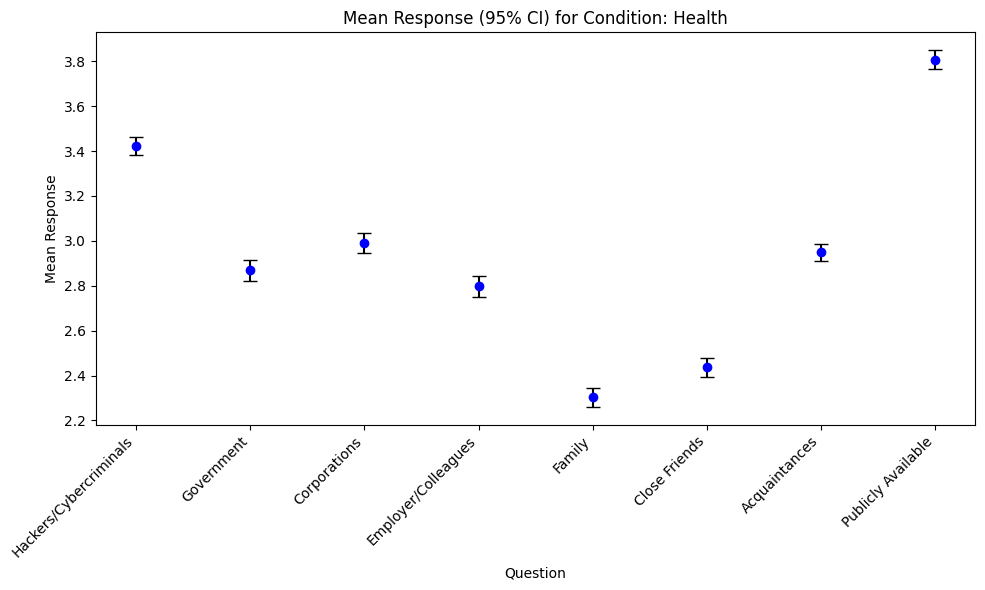

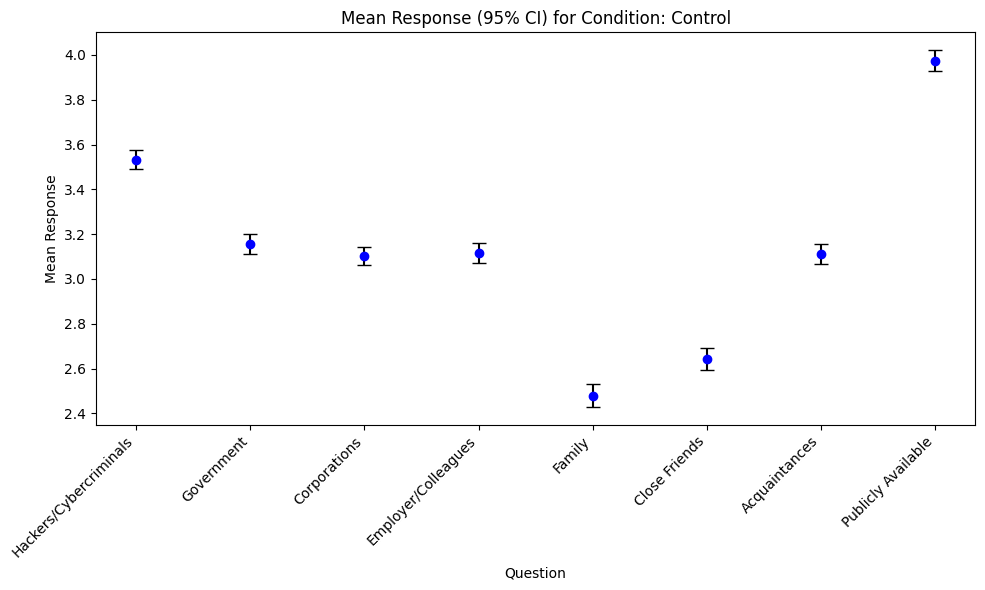

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

# Dictionary mapping question codes to descriptive labels
custom_labels = {
    'Q1': 'Hackers/Cybercriminals',
    'Q2': 'Government',
    'Q3': 'Corporations',
    'Q4': 'Employer/Colleagues',
    'Q5': 'Family',
    'Q6': 'Close Friends',
    'Q7': 'Acquaintances',
    'Q8': 'Publicly Available'
}

# Assume `grouped_df` has one row per (SyntheticPersonID, Condition),
# with columns: ["SyntheticPersonID", "Condition", "Q1", "Q2", ..., "Q8"].

questions = ["Q1","Q2","Q3","Q4","Q5","Q6","Q7","Q8"]
conditions = grouped_df["Condition"].unique()

for cond in conditions:
    # Filter data for this condition
    cond_data = grouped_df[grouped_df["Condition"] == cond]

    # Compute means and standard deviations for each question
    mean_vals = cond_data[questions].mean(axis=0)
    std_vals  = cond_data[questions].std(axis=0)

    # Number of SyntheticPersonIDs in this condition
    n = cond_data.shape[0]

    # Standard error for each question
    se_vals = std_vals / np.sqrt(n)  # If n <= 1, be mindful of dividing by zero

    # 95% CI using the t-distribution (two-tailed)
    if n > 1:
        t_multiplier = st.t.ppf(1 - 0.025, df=n-1)
        ci_vals = t_multiplier * se_vals
    else:
        # If there's only one data point in this condition, CI is not meaningful
        ci_vals = np.zeros_like(se_vals)

    # X positions for plotting
    x_positions = np.arange(len(questions))

    # Create the plot
    plt.figure(figsize=(10,6))
    plt.errorbar(
        x_positions,
        mean_vals,
        yerr=ci_vals,
        fmt='o',
        capsize=5,
        color='blue',
        ecolor='black'
    )

    # Use custom labels for the questions
    question_labels = [custom_labels[q] for q in questions]

    plt.xticks(x_positions, question_labels, rotation=45, ha='right')
    plt.xlabel("Question")
    plt.ylabel("Mean Response")
    plt.title(f"Mean Response (95% CI) for Condition: {cond}")

    plt.tight_layout()
    plt.show()

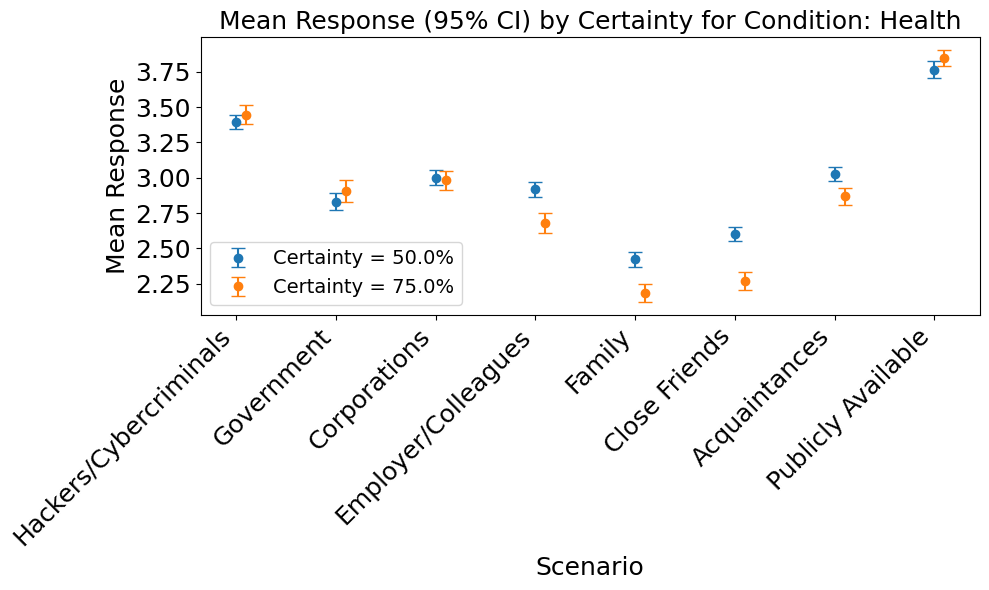

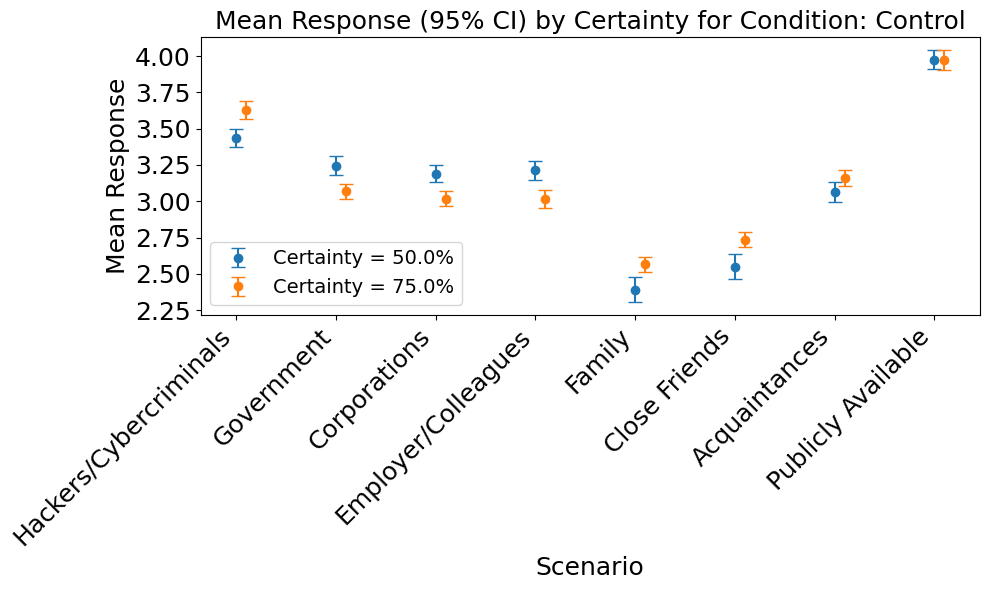

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

# Dictionary mapping question codes to descriptive labels
custom_labels = {
    'Q1': 'Hackers/Cybercriminals',
    'Q2': 'Government',
    'Q3': 'Corporations',
    'Q4': 'Employer/Colleagues',
    'Q5': 'Family',
    'Q6': 'Close Friends',
    'Q7': 'Acquaintances',
    'Q8': 'Publicly Available'
}

# Assume `grouped_df` has one row per (SyntheticPersonID, Condition),
# with columns: ["SyntheticPersonID", "Condition", "Q1", "Q2", ..., "Q8"].

questions = ["Q1","Q2","Q3","Q4","Q5","Q6","Q7","Q8"]
conditions = grouped_df["Condition"].unique()

# Sort certainties if needed (e.g., 50, then 75)
certainties = grouped_df["Certainty"].unique()
certainties = sorted(certainties)

for cond in conditions:
    plt.figure(figsize=(10, 6))

    for i, cert in enumerate(certainties):
        subset = grouped_df[
            (grouped_df["Condition"] == cond) &
            (grouped_df["Certainty"] == cert)
        ]

        mean_vals = subset[questions].mean(axis=0)
        std_vals  = subset[questions].std(axis=0)
        n = subset.shape[0]
        se_vals = std_vals / np.sqrt(n) if n > 1 else np.zeros_like(std_vals)

        if n > 1:
            t_multiplier = st.t.ppf(1 - 0.025, df=n-1)
            ci_vals = t_multiplier * se_vals
        else:
            ci_vals = np.zeros_like(se_vals)

        x_positions = np.arange(len(questions))
        offset = i * 0.1
        shifted_positions = x_positions + offset

        plt.errorbar(
            shifted_positions,
            mean_vals,
            yerr=ci_vals,
            fmt='o',
            capsize=5,
            label=f"Certainty = {cert}%"
        )

    question_labels = [custom_labels[q] for q in questions]
    plt.xticks(np.arange(len(questions)), question_labels, rotation=45, ha='right', fontsize=18)
    plt.yticks(fontsize=18)

    plt.xlabel("Scenario", fontsize=18)
    plt.ylabel("Mean Response", fontsize=18)
    plt.title(f"Mean Response (95% CI) by Certainty for Condition: {cond}", fontsize=18)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.savefig(f'mean_response_{cond}.pdf', bbox_inches='tight')
    plt.show()

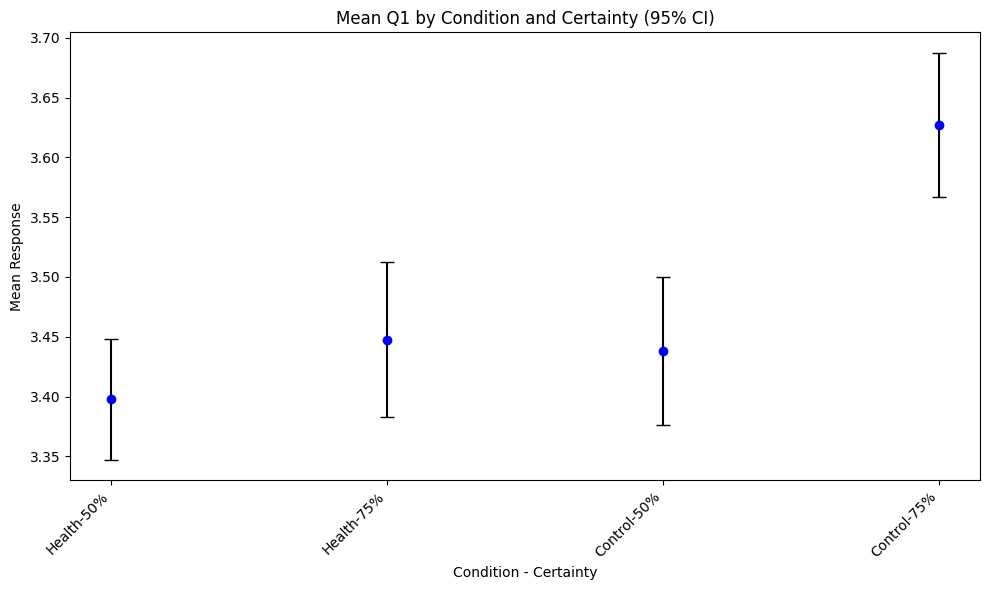

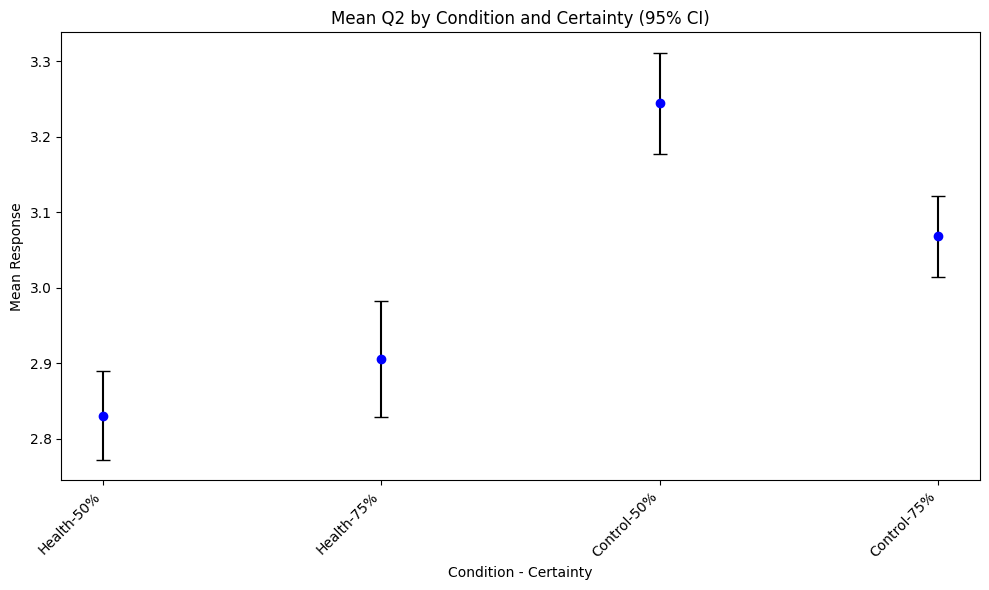

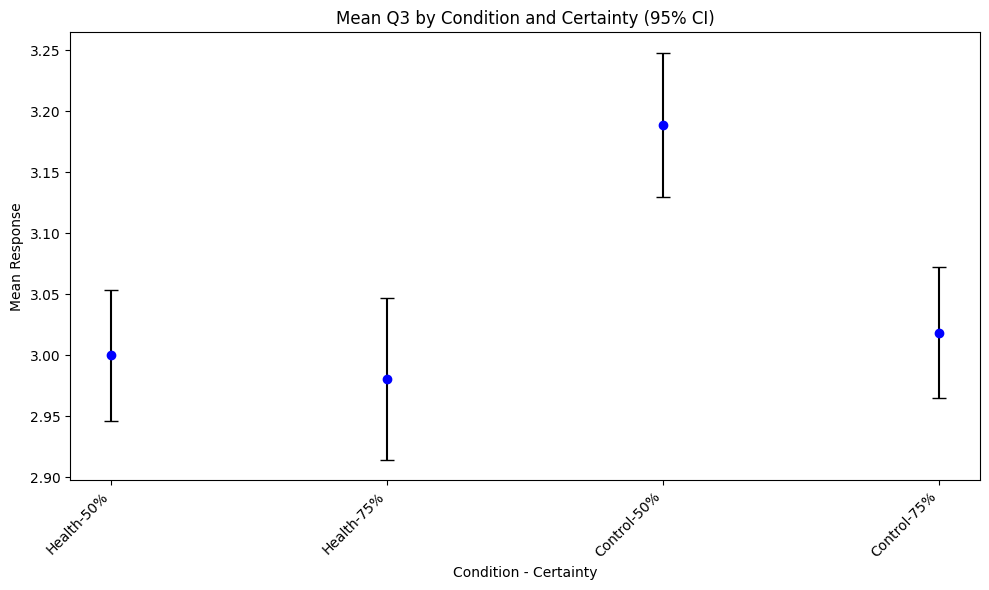

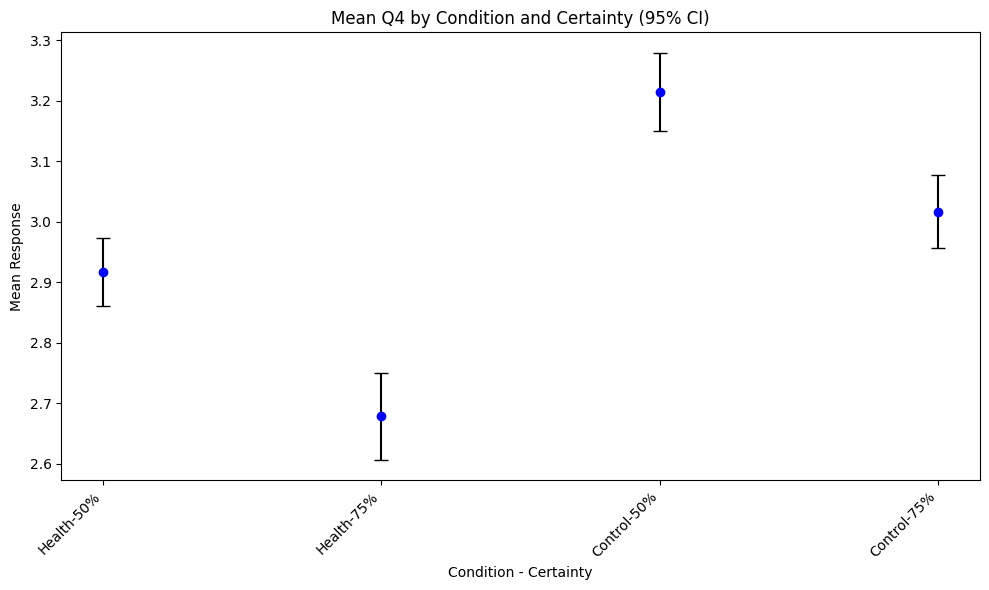

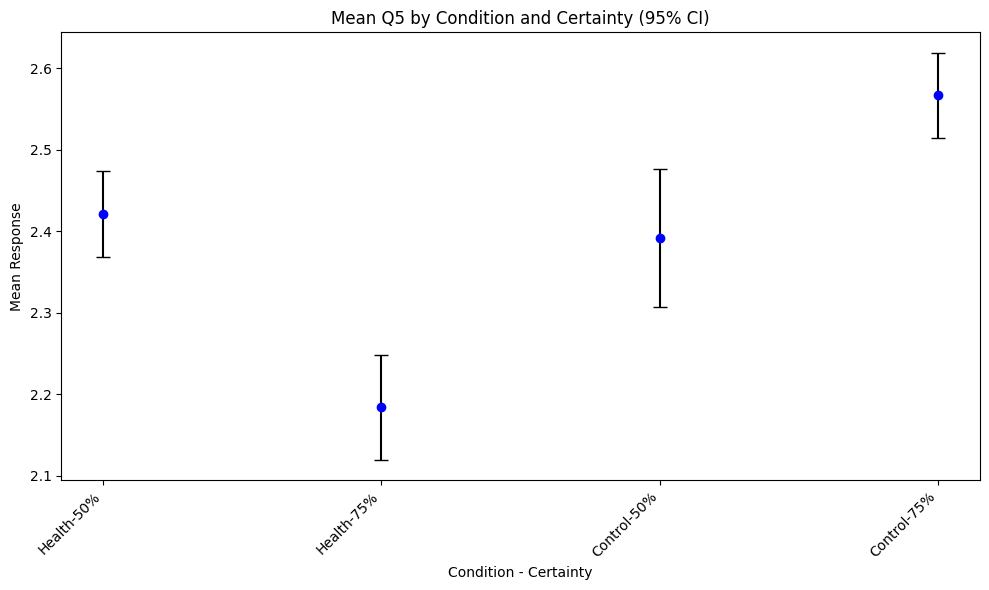

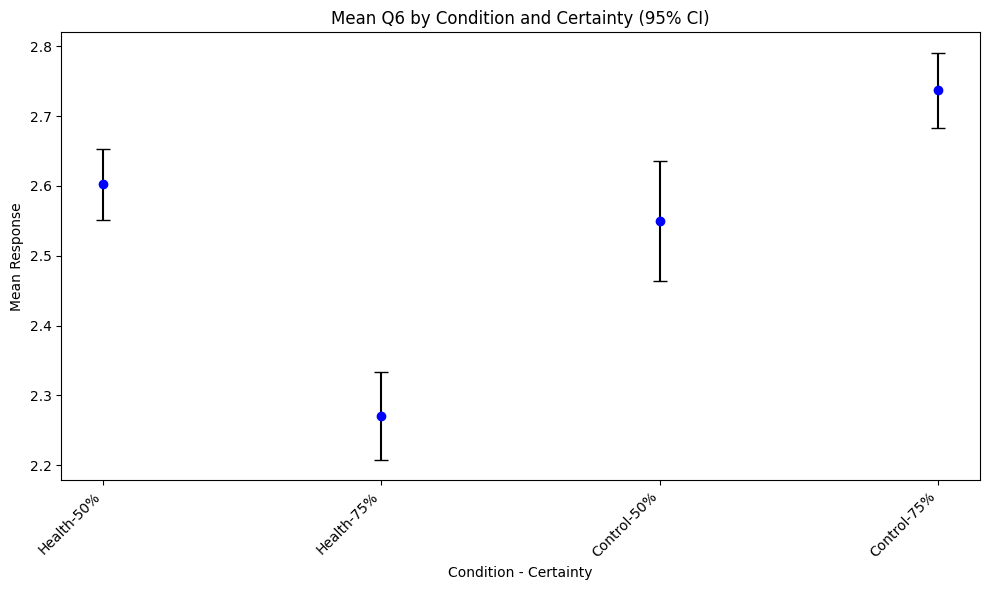

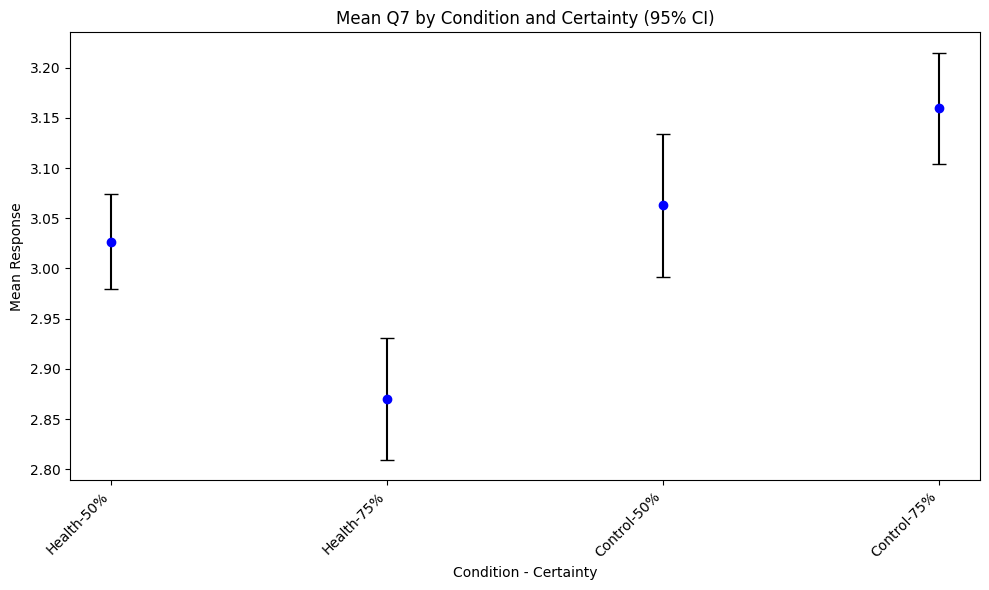

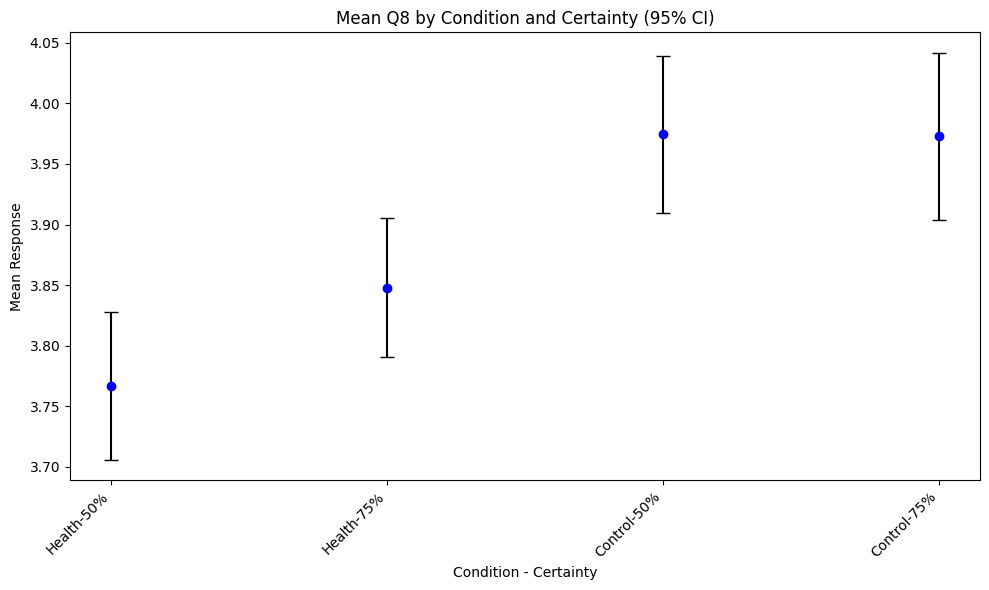

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

# Assume grouped_df has one row per (SyntheticPersonID, Condition, Certainty) and columns for Q1..Q8, like:
# ["SyntheticPersonID", "Condition", "Certainty", "Q1", "Q2", ..., "Q8"]

questions = ["Q1","Q2","Q3","Q4","Q5","Q6","Q7","Q8"]
conditions = grouped_df["Condition"].unique()
certainties = sorted(grouped_df["Certainty"].unique())  # e.g., [50, 75]

for question in questions:
    # Prepare lists to store the mean, CI, and x-axis labels
    means = []
    ci_vals = []
    x_labels = []

    # Loop over each Condition and Certainty combination
    for cond in conditions:
        for cert in certainties:
            # Filter rows that match the current Condition and Certainty
            subset = grouped_df.loc[
                (grouped_df["Condition"] == cond) & (grouped_df["Certainty"] == cert),
                question
            ].dropna()

            mean_val = subset.mean()
            std_val = subset.std()
            n = subset.shape[0]

            # Compute 95% CI using the t-distribution
            if n > 1:
                se_val = std_val / np.sqrt(n)
                t_multiplier = st.t.ppf(1 - 0.025, df=n-1)  # for a 95% CI
                ci = t_multiplier * se_val
            else:
                # If there's only one data point, the CI isn't meaningful
                ci = 0.0

            means.append(mean_val)
            ci_vals.append(ci)
            x_labels.append(f"{cond}-{int(cert)}%")  # e.g. "Health-50%" or "Control-75%"

    # X positions for plotting
    x_positions = np.arange(len(means))

    plt.figure(figsize=(10, 6))
    plt.errorbar(
        x_positions,
        means,
        yerr=ci_vals,
        fmt='o',
        capsize=5,
        color='blue',
        ecolor='black'
    )

    plt.xticks(x_positions, x_labels, rotation=45, ha='right')
    plt.xlabel("Condition - Certainty")
    plt.ylabel("Mean Response")
    plt.title(f"Mean {question} by Condition and Certainty (95% CI)")
    plt.tight_layout()
    plt.show()

In [12]:
import scipy.stats as stats

score_types = ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"]
conditions_of_interest = ["Health", "Control"]

for cond in conditions_of_interest:
    print(f"\n=== Condition: {cond} ===")

    # Subset the data for just this condition
    subset_cond = grouped_df[grouped_df["Condition"] == cond]

    for score in score_types:
        # Separate data for 50% vs 75% certainty
        data_50 = subset_cond[subset_cond["Certainty"] == 50][score].dropna()
        data_75 = subset_cond[subset_cond["Certainty"] == 75][score].dropna()

        # Only run a t-test if both groups have sufficient data
        if len(data_50) >= 2 and len(data_75) >= 2:
            t_stat, p_val = stats.ttest_ind(data_50, data_75, equal_var=False)
            print(f"{score} | t = {t_stat:.3f}, p = {p_val:.3e}")
        else:
            print(f"{score} | Not enough data for t-test.")


=== Condition: Health ===
Q1 | t = -1.197, p = 2.316e-01
Q2 | t = -1.531, p = 1.262e-01
Q3 | t = 0.447, p = 6.551e-01
Q4 | t = 5.150, p = 3.133e-07
Q5 | t = 5.590, p = 2.904e-08
Q6 | t = 8.073, p = 1.914e-15
Q7 | t = 4.011, p = 6.482e-05
Q8 | t = -1.906, p = 5.687e-02

=== Condition: Control ===
Q1 | t = -4.298, p = 1.885e-05
Q2 | t = 4.054, p = 5.414e-05
Q3 | t = 4.196, p = 2.944e-05
Q4 | t = 4.388, p = 1.260e-05
Q5 | t = -3.446, p = 5.949e-04
Q6 | t = -3.640, p = 2.887e-04
Q7 | t = -2.112, p = 3.495e-02
Q8 | t = 0.032, p = 9.741e-01


In [14]:
df_responses = pd.read_csv('prolific_responses_survey2.csv')  # Adjust filename/path as needed
df_prolific  = pd.read_csv('prolific_export_survey2.csv')  # Adjust filename/path as needed

# Define the mapping from Likert-scale text to numbers
likert_mapping = {
    "Not at all harmful": 1,
    "Slightly harmful": 2,
    "Moderately harmful": 3,
    "Very harmful": 4,
    "Extremely harmful": 5
}

# List the columns that contain Likert-scale responses.
# Update this list to include all columns that need conversion.
likert_columns = ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"]

# Replace the text values with numeric values in those columns
for col in likert_columns:
    if col in df.columns:  # only replace if column exists in the dataframe
        df_responses[col] = df_responses[col].replace(likert_mapping)

merged_df = pd.merge(df_responses, df_prolific,
                     left_on='ProlificID',
                     right_on='Participant id',
                     how='inner')

# Now merged_df contains columns from both datasets.
print("Merged DataFrame:")
print(merged_df.head())

questions = ["Q1","Q2","Q3","Q4","Q5","Q6","Q7","Q8"]

Merged DataFrame:
                 ProlificID  SyntheticPersonID AttnCheck  Q1  Q2  Q3  Q4  Q5  \
0  6738e2f6443d73fad19d2753              14226       NaN   3   1   4   1   2   
1  6738e2f6443d73fad19d2753               1373       NaN   3   1   3   1   2   
2  6738e2f6443d73fad19d2753              10468       NaN   3   1   2   1   2   
3  6738e2f6443d73fad19d2753              13101       NaN   4   1   2   1   2   
4  6738e2f6443d73fad19d2753               3933       NaN   3   1   2   1   2   

   Q6  Q7  ...  Total approvals Age   Sex Ethnicity simplified  \
0   2   3  ...              142  20  Male                Asian   
1   2   2  ...              142  20  Male                Asian   
2   2   2  ...              142  20  Male                Asian   
3   2   2  ...              142  20  Male                Asian   
4   2   2  ...              142  20  Male                Asian   

  Country of birth Country of residence Nationality Language Student status  \
0    United States       

/tmp/ipython-input-1363003977.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_responses[col] = df_responses[col].replace(likert_mapping)


In [15]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import itertools

# Define the questions and the demographic columns to analyze
questions = ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"]

# List of demographic columns (categorical) from the Prolific export.
# Update this list based on the columns available in your prolific_export.
demographic_vars = ["Sex", "Ethnicity simplified", "Country of residence", "Language", "Employment status"]

# Prepare a list to store the t-test results
results = []

# Loop over each demographic variable
for demo in demographic_vars:
    # Get the unique groups in this demographic (drop missing values)
    groups = merged_df[demo].dropna().unique()

    # If there are less than 2 groups, skip this demographic.
    if len(groups) < 2:
        continue

    # For each question, perform pairwise comparisons between groups in this demographic.
    for question in questions:
        # Use itertools.combinations to get all unique pairwise comparisons.
        for group1, group2 in itertools.combinations(groups, 2):
            # Filter data for each group for the given question
            data1 = merged_df.loc[merged_df[demo] == group1, question].dropna()
            data2 = merged_df.loc[merged_df[demo] == group2, question].dropna()

            # Only perform the t-test if both groups have at least 2 observations
            if len(data1) >= 2 and len(data2) >= 2:
                t_stat, p_val = stats.ttest_ind(data1, data2, equal_var=False)
            else:
                t_stat, p_val = np.nan, np.nan  # Not enough data

            results.append((demo, question, group1, group2, t_stat, p_val))

# Convert the results list to a DataFrame for easier viewing
results_df = pd.DataFrame(results, columns=["Demographic", "Question", "Group1", "Group2", "t_stat", "p_value"])

# Optionally, adjust p-values for multiple comparisons using Bonferroni correction.
from statsmodels.stats.multitest import multipletests
adjusted = multipletests(results_df["p_value"].dropna(), method="bonferroni")
# Place adjusted p-values back into the results DataFrame.
# (needing to match the indices since multipletests was applied to non-NaN values.)
results_df.loc[results_df["p_value"].notna(), "p_adjusted"] = adjusted[1]

# Display the results
print("Pairwise t-test results for each question by demographic variable:")
print(results_df)
# get df to csv
results_df.to_csv('t-tests_survey2.csv', index=False)

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Pairwise t-test results for each question by demographic variable:
           Demographic Question  \
0                  Sex       Q1   
1                  Sex       Q1   
2                  Sex       Q1   
3                  Sex       Q2   
4                  Sex       Q2   
..                 ...      ...   
595  Employment status       Q8   
596  Employment status       Q8   
597  Employment status       Q8   
598  Employment status       Q8   
599  Employment status       Q8   

                                                Group1  \
0                                                 Male   
1                                                 Male   
2                                               Female   
3                                                 Male   
4                                                 Male   
..                                                 ...   
595  Not in paid work (e.g. homemaker', 'retired or...   
596  Not in paid work (e.g. homemaker', 'retired

## Supervised ML

In [16]:
from sklearn.preprocessing import LabelEncoder

feature_list = ["GENDER", "RACETHN", "EDUCCAT5", "DIVISION", "MARITAL_ACS",
                "CHILDRENCAT", "CITIZEN_REC", "BORN_ACS", "AGE_INT",
                "HIV_STAT", "PREG_STAT", "NumChronicIllness",
                "FAMINC5", "CC_NUM", "FDSTMP_CPS",
                "SEXUALITY", "OWNGUN_GSS", "RELIGCAT", "Certainty"
]

In [17]:
df_synthetic.head()

,,NAME,id,GENDER,AGE,RACETHN,EDUCCAT5,DIVISION,MARITAL_ACS,HHSIZECAT,...,CI_LABEL_OWNGUN_GSS,CI_LABEL_SEXUALITY,CI_LABEL_HIV_STAT,CI_LABEL_PREG_STAT,CI_LABEL_CC_NUM,CI_LABEL_cc_encoded,CI_LABEL_cc_disclosed,CI_LABEL_NumChronicIllness,AGE_INT,Cluster
0,0,Luke Walsh,1,Male,25,White non-Hispanic,Some college,Mountain,Never married,3+,...,is,is,is probably,is probably,is,is probably,is possibly,is probably,20-29,5
1,1,Matilde Izaguirre Checa,2,Female,70,Hispanic,HS Grad,West South Central,Divorced,1,...,is probably,is possibly,is,is,is,is,is,is possibly,70-79,11
2,2,Ryan Smith,3,Male,85,White non-Hispanic,Less than HS,Middle Atlantic,Now married,2,...,is possibly,is probably,is probably,is,is probably,is probably,is probably,is probably,80-89,2
3,3,Matthew Grimes,4,Male,59,White non-Hispanic,HS Grad,Mountain,Now married,2,...,is probably,is probably,is probably,is,is possibly,is probably,is,is probably,50-59,12
4,4,Miraan Rama,5,Female,19,Asian,Some college,Pacific,Never married,1,...,is probably,is,is probably,is,is probably,is probably,is probably,is,10-19,9


In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [19]:
import pandas as pd

df_merged = pd.merge(
    df_synthetic,
    df_avg,
    how="left",
    left_on="id",
    right_on="SyntheticPersonID",
    suffixes=("", "_drop")
)

cols_to_drop = [col for col in df_merged.columns if col.endswith("_drop")]
df_final = df_merged.drop(columns=cols_to_drop)
df_final = df_final.fillna(0)

print(df_final.head())

                         NAME  id  GENDER  AGE             RACETHN  \
0  0               Luke Walsh   1    Male   25  White non-Hispanic   
1  1  Matilde Izaguirre Checa   2  Female   70            Hispanic   
2  2               Ryan Smith   3    Male   85  White non-Hispanic   
3  3           Matthew Grimes   4    Male   59  White non-Hispanic   
4  4              Miraan Rama   5  Female   19               Asian   

       EDUCCAT5            DIVISION    MARITAL_ACS HHSIZECAT  ...   Q1   Q2  \
0  Some college            Mountain  Never married        3+  ...  0.0  0.0   
1       HS Grad  West South Central       Divorced         1  ...  0.0  0.0   
2  Less than HS     Middle Atlantic    Now married         2  ...  0.0  0.0   
3       HS Grad            Mountain    Now married         2  ...  0.0  0.0   
4  Some college             Pacific  Never married         1  ...  0.0  0.0   

    Q3   Q4   Q5   Q6   Q7   Q8 Certainty avg_harm  
0  0.0  0.0  0.0  0.0  0.0  0.0       0.0      0.0 

In [20]:
# for the rows where Certainty is 0, randomly assign them a value of 50 or 75
df_final.loc[df_final['Certainty'] == 0, 'Certainty'] = np.random.choice([50, 75], size=df_final.loc[df_final['Certainty'] == 0].shape[0])

In [21]:
train_data = df_final[df_final['Q1'] > 0]
predict_data = df_final[df_final['Q1'] == 0]

X_train = train_data[feature_list]
y_train = train_data['Q1']

onehot_encoder = OneHotEncoder(
    sparse_output=False,
    handle_unknown='ignore',
    drop='first'
)

X_train_encoded = onehot_encoder.fit_transform(X_train.astype(str))

scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()

models = [
    ('RandomForest', RandomForestRegressor(n_estimators=100)),
    ('GradientBoosting', GradientBoostingRegressor()),
    ('LinearRegression', LinearRegression()),
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('DecisionTree', DecisionTreeRegressor()),
    ('SVR', SVR())
]

def evaluate_model(model_name, model, X_train, y_train):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    mse = mean_squared_error(y_train, y_train_pred)
    r2 = r2_score(y_train, y_train_pred)
    print(f'Model: {model_name}')
    print(f'MSE on training data: {mse}')
    print(f'R^2 on training data: {r2}\n')

for name, model in models:
    evaluate_model(name, model, X_train_encoded, y_train_scaled)

Model: RandomForest
MSE on training data: 0.1425494252464543
R^2 on training data: 0.8574505747535457

Model: GradientBoosting
MSE on training data: 0.8643992922468302
R^2 on training data: 0.1356007077531698

Model: LinearRegression
MSE on training data: 0.12443103062698671
R^2 on training data: 0.8755689693730133

Model: Ridge
MSE on training data: 0.3498706291084605
R^2 on training data: 0.6501293708915394

Model: Lasso
MSE on training data: 1.0
R^2 on training data: 0.0

Model: DecisionTree
MSE on training data: 7.095531374058237e-34
R^2 on training data: 1.0

Model: SVR
MSE on training data: 0.6157409795108677
R^2 on training data: 0.3842590204891323



In [22]:
questions = ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"]
for q in questions:

  train_data = df_final[df_final[q] > 0]
  predict_data = df_final[df_final[q] == 0]

  X_train = train_data[feature_list]
  y_train = train_data[q]

  onehot_encoder = OneHotEncoder(
      sparse_output=False,
      handle_unknown='ignore',
      drop='first'
  )

  X_train_encoded = onehot_encoder.fit_transform(X_train.astype(str))

  scaler = StandardScaler()
  y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()

  models = [
      ('DecisionTree', DecisionTreeRegressor())
  ]

  def evaluate_model(model_name, model, X_train, y_train):
      model.fit(X_train, y_train)
      y_train_pred = model.predict(X_train)
      mse = mean_squared_error(y_train, y_train_pred)
      r2 = r2_score(y_train, y_train_pred)
      print(f'Model: {model_name}')
      print(f'MSE on training data: {mse}')
      print(f'R^2 on training data: {r2}\n')

  for name, model in models:
      evaluate_model(name, model, X_train_encoded, y_train_scaled)


  best_model = DecisionTreeRegressor(
      max_depth=30,
      max_features=None,
      min_samples_leaf=4,
      min_samples_split=5,
      random_state=42
  )
  best_model.fit(X_train_encoded, y_train_scaled)

  X_predict = predict_data[feature_list]
  X_predict_encoded = onehot_encoder.transform(X_predict.astype(str))
  predicted_scores_scaled = best_model.predict(X_predict_encoded)

  predicted_scores = scaler.inverse_transform(predicted_scores_scaled.reshape(-1, 1)).flatten()

  df_final.loc[df_final[q] == 0, q] = predicted_scores

  print(df_final.head())

Model: DecisionTree
MSE on training data: 9.267632815096473e-34
R^2 on training data: 1.0



/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


                         NAME  id  GENDER  AGE             RACETHN  \
0  0               Luke Walsh   1    Male   25  White non-Hispanic   
1  1  Matilde Izaguirre Checa   2  Female   70            Hispanic   
2  2               Ryan Smith   3    Male   85  White non-Hispanic   
3  3           Matthew Grimes   4    Male   59  White non-Hispanic   
4  4              Miraan Rama   5  Female   19               Asian   

       EDUCCAT5            DIVISION    MARITAL_ACS HHSIZECAT  ...        Q1  \
0  Some college            Mountain  Never married        3+  ...  3.666667   
1       HS Grad  West South Central       Divorced         1  ...  3.354167   
2  Less than HS     Middle Atlantic    Now married         2  ...  3.562500   
3       HS Grad            Mountain    Now married         2  ...  3.979167   
4  Some college             Pacific  Never married         1  ...  3.354167   

    Q2   Q3   Q4   Q5   Q6   Q7   Q8 Certainty avg_harm  
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      50.0

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


                         NAME  id  GENDER  AGE             RACETHN  \
0  0               Luke Walsh   1    Male   25  White non-Hispanic   
1  1  Matilde Izaguirre Checa   2  Female   70            Hispanic   
2  2               Ryan Smith   3    Male   85  White non-Hispanic   
3  3           Matthew Grimes   4    Male   59  White non-Hispanic   
4  4              Miraan Rama   5  Female   19               Asian   

       EDUCCAT5            DIVISION    MARITAL_ACS HHSIZECAT  ...        Q1  \
0  Some college            Mountain  Never married        3+  ...  3.666667   
1       HS Grad  West South Central       Divorced         1  ...  3.354167   
2  Less than HS     Middle Atlantic    Now married         2  ...  3.562500   
3       HS Grad            Mountain    Now married         2  ...  3.979167   
4  Some college             Pacific  Never married         1  ...  3.354167   

         Q2   Q3   Q4   Q5   Q6   Q7   Q8 Certainty avg_harm  
0  3.316667  0.0  0.0  0.0  0.0  0.0  0.0

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


                         NAME  id  GENDER  AGE             RACETHN  \
0  0               Luke Walsh   1    Male   25  White non-Hispanic   
1  1  Matilde Izaguirre Checa   2  Female   70            Hispanic   
2  2               Ryan Smith   3    Male   85  White non-Hispanic   
3  3           Matthew Grimes   4    Male   59  White non-Hispanic   
4  4              Miraan Rama   5  Female   19               Asian   

       EDUCCAT5            DIVISION    MARITAL_ACS HHSIZECAT  ...        Q1  \
0  Some college            Mountain  Never married        3+  ...  3.666667   
1       HS Grad  West South Central       Divorced         1  ...  3.354167   
2  Less than HS     Middle Atlantic    Now married         2  ...  3.562500   
3       HS Grad            Mountain    Now married         2  ...  3.979167   
4  Some college             Pacific  Never married         1  ...  3.354167   

         Q2        Q3   Q4   Q5   Q6   Q7   Q8 Certainty avg_harm  
0  3.316667  2.883333  0.0  0.0  0.0

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


                         NAME  id  GENDER  AGE             RACETHN  \
0  0               Luke Walsh   1    Male   25  White non-Hispanic   
1  1  Matilde Izaguirre Checa   2  Female   70            Hispanic   
2  2               Ryan Smith   3    Male   85  White non-Hispanic   
3  3           Matthew Grimes   4    Male   59  White non-Hispanic   
4  4              Miraan Rama   5  Female   19               Asian   

       EDUCCAT5            DIVISION    MARITAL_ACS HHSIZECAT  ...        Q1  \
0  Some college            Mountain  Never married        3+  ...  3.666667   
1       HS Grad  West South Central       Divorced         1  ...  3.354167   
2  Less than HS     Middle Atlantic    Now married         2  ...  3.562500   
3       HS Grad            Mountain    Now married         2  ...  3.979167   
4  Some college             Pacific  Never married         1  ...  3.354167   

         Q2        Q3        Q4   Q5   Q6   Q7   Q8 Certainty avg_harm  
0  3.316667  2.883333  2.266667

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


                         NAME  id  GENDER  AGE             RACETHN  \
0  0               Luke Walsh   1    Male   25  White non-Hispanic   
1  1  Matilde Izaguirre Checa   2  Female   70            Hispanic   
2  2               Ryan Smith   3    Male   85  White non-Hispanic   
3  3           Matthew Grimes   4    Male   59  White non-Hispanic   
4  4              Miraan Rama   5  Female   19               Asian   

       EDUCCAT5            DIVISION    MARITAL_ACS HHSIZECAT  ...        Q1  \
0  Some college            Mountain  Never married        3+  ...  3.666667   
1       HS Grad  West South Central       Divorced         1  ...  3.354167   
2  Less than HS     Middle Atlantic    Now married         2  ...  3.562500   
3       HS Grad            Mountain    Now married         2  ...  3.979167   
4  Some college             Pacific  Never married         1  ...  3.354167   

         Q2        Q3        Q4        Q5   Q6   Q7   Q8 Certainty avg_harm  
0  3.316667  2.883333  2.2

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


                         NAME  id  GENDER  AGE             RACETHN  \
0  0               Luke Walsh   1    Male   25  White non-Hispanic   
1  1  Matilde Izaguirre Checa   2  Female   70            Hispanic   
2  2               Ryan Smith   3    Male   85  White non-Hispanic   
3  3           Matthew Grimes   4    Male   59  White non-Hispanic   
4  4              Miraan Rama   5  Female   19               Asian   

       EDUCCAT5            DIVISION    MARITAL_ACS HHSIZECAT  ...        Q1  \
0  Some college            Mountain  Never married        3+  ...  3.666667   
1       HS Grad  West South Central       Divorced         1  ...  3.354167   
2  Less than HS     Middle Atlantic    Now married         2  ...  3.562500   
3       HS Grad            Mountain    Now married         2  ...  3.979167   
4  Some college             Pacific  Never married         1  ...  3.354167   

         Q2        Q3        Q4        Q5        Q6   Q7   Q8 Certainty  \
0  3.316667  2.883333  2.2666

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


                         NAME  id  GENDER  AGE             RACETHN  \
0  0               Luke Walsh   1    Male   25  White non-Hispanic   
1  1  Matilde Izaguirre Checa   2  Female   70            Hispanic   
2  2               Ryan Smith   3    Male   85  White non-Hispanic   
3  3           Matthew Grimes   4    Male   59  White non-Hispanic   
4  4              Miraan Rama   5  Female   19               Asian   

       EDUCCAT5            DIVISION    MARITAL_ACS HHSIZECAT  ...        Q1  \
0  Some college            Mountain  Never married        3+  ...  3.666667   
1       HS Grad  West South Central       Divorced         1  ...  3.354167   
2  Less than HS     Middle Atlantic    Now married         2  ...  3.562500   
3       HS Grad            Mountain    Now married         2  ...  3.979167   
4  Some college             Pacific  Never married         1  ...  3.354167   

         Q2        Q3        Q4        Q5        Q6        Q7   Q8 Certainty  \
0  3.316667  2.883333  2

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


                         NAME  id  GENDER  AGE             RACETHN  \
0  0               Luke Walsh   1    Male   25  White non-Hispanic   
1  1  Matilde Izaguirre Checa   2  Female   70            Hispanic   
2  2               Ryan Smith   3    Male   85  White non-Hispanic   
3  3           Matthew Grimes   4    Male   59  White non-Hispanic   
4  4              Miraan Rama   5  Female   19               Asian   

       EDUCCAT5            DIVISION    MARITAL_ACS HHSIZECAT  ...        Q1  \
0  Some college            Mountain  Never married        3+  ...  3.666667   
1       HS Grad  West South Central       Divorced         1  ...  3.354167   
2  Less than HS     Middle Atlantic    Now married         2  ...  3.562500   
3       HS Grad            Mountain    Now married         2  ...  3.979167   
4  Some college             Pacific  Never married         1  ...  3.354167   

         Q2        Q3        Q4        Q5        Q6        Q7        Q8  \
0  3.316667  2.883333  2.2666

In [23]:
# drop syntheticpersonid column
df_final = df_final.drop(columns=['SyntheticPersonID'])

# Participant Graphs

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

def plot_responses(df, question, demographic, kind="bar"):
    """
    Visualize responses for one question by a demographic group.

    Parameters
    ----------
    df : pandas.DataFrame
        Your merged survey dataframe.
    question : str
        Column name of the question (e.g., 'Q5').
    demographic : str
        Column name of the demographic variable (e.g., 'Sex').
    kind : {'bar', 'violin', 'box'}, optional
        Plot type (default 'bar').
    """
    plt.figure(figsize=(10, 5))

    if kind == "bar":
        sns.barplot(data=df, x=demographic, y=question, ci="sd", palette="muted")
    elif kind == "violin":
        sns.violinplot(data=df, x=demographic, y=question, inner="quartile", palette="Set3")
    elif kind == "box":
        sns.boxplot(data=df, x=demographic, y=question, palette="Set2")

    plt.title(f"{question} responses by {demographic}")
    plt.ylabel("Likert Score")
    plt.xlabel(demographic)
    plt.ylim(1, 5)  # assuming a 1–5 Likert scale
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

/tmp/ipython-input-777441008.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=demographic, y=question, inner="quartile", palette="Set3")


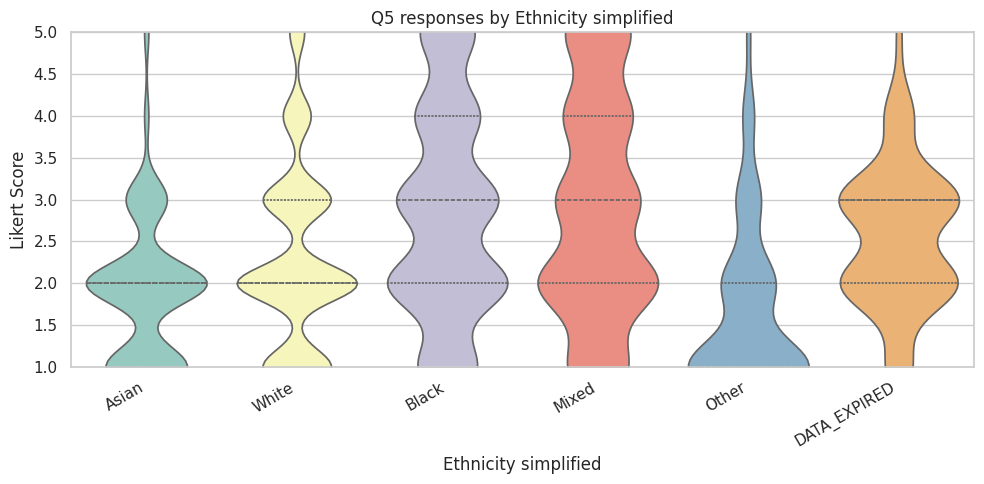

In [27]:
plot_responses(merged_df, question="Q5", demographic="Ethnicity simplified", kind="violin")

/tmp/ipython-input-2365677643.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")


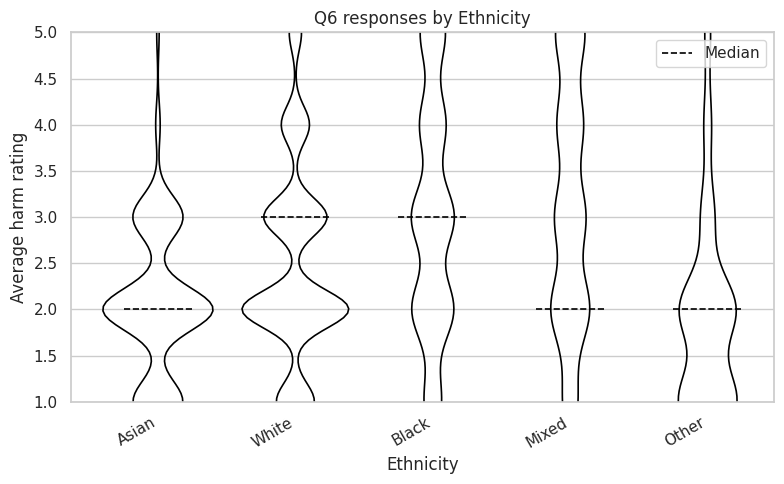

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(8, 5))

# Draw violins without internal lines
sns.violinplot(
    data=merged_df[merged_df["Ethnicity simplified"] != "DATA_EXPIRED"],
    x="Ethnicity simplified",
    y="Q6",
    inner=None,           # <-- remove quartile/median lines
    fill=False,
    color="black",
    linewidth=1.2,
    ax=ax
)

# Overlay the median manually
grouped = (
    merged_df[merged_df["Ethnicity simplified"] != "DATA_EXPIRED"]
    .groupby("Ethnicity simplified")["Q6"]
    .median()
)

for i, (group, median) in enumerate(grouped.items()):
    ax.hlines(
        median,
        i - 0.25, i + 0.25,   # small horizontal line around the center
        color="black",
        linestyles="--",
        linewidth=1.2,
        label="Median" if i == 0 else ""
    )

ax.set_title("Q6 responses by Ethnicity")
ax.set_xlabel("Ethnicity")
ax.set_ylabel("Average harm rating")
ax.set_ylim(1, 5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")

# Only one legend entry
ax.legend(loc="upper right")

plt.tight_layout()

# Save BEFORE show, only once
plt.savefig("q6_ethnicity_violin.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

sns.set(style="whitegrid")

def plot_responses(df, question, demographic, kind="bar"):
    plt.figure(figsize=(10, 5))
    if kind == "bar":
        sns.barplot(data=df, x=demographic, y=question, ci="sd", palette="muted")
    elif kind == "violin":
        sns.violinplot(data=df, x=demographic, y=question, inner="quartile", palette="Set3")
    elif kind == "box":
        sns.boxplot(data=df, x=demographic, y=question, palette="Set2")
    plt.title(f"{question} responses by {demographic}")
    plt.ylabel("Likert Score")
    plt.xlabel(demographic)
    plt.ylim(1, 5)  # Likert scale
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()

# >>> Replace this with your real dataframe
df = merged_df

questions = [f"Q{i}" for i in range(1, 9)]
demographics = [
    "Sex",
    "Ethnicity simplified",
    "Country of residence",
    "Language",
    "Employment status",
]

output_path = "survey_plots.pdf"
with PdfPages(output_path) as pdf:
    for q in questions:
        for demo in demographics:
            plot_responses(df, q, demo, kind="violin")
            pdf.savefig()  # save the current figure
            plt.close()

print(f"PDF saved to {output_path}")

/tmp/ipython-input-1277976467.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=demographic, y=question, inner="quartile", palette="Set3")
/tmp/ipython-input-1277976467.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=demographic, y=question, inner="quartile", palette="Set3")
/tmp/ipython-input-1277976467.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x=demographic, y=question, inner="quartile", palette="Set3")
/tmp/ipython-input-1277976467.py:13: FutureWarning: 

Passing `palette` without

PDF saved to survey_plots.pdf


## Graphs

/tmp/ipython-input-1025736540.py:28: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(
/tmp/ipython-input-1025736540.py:43: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(


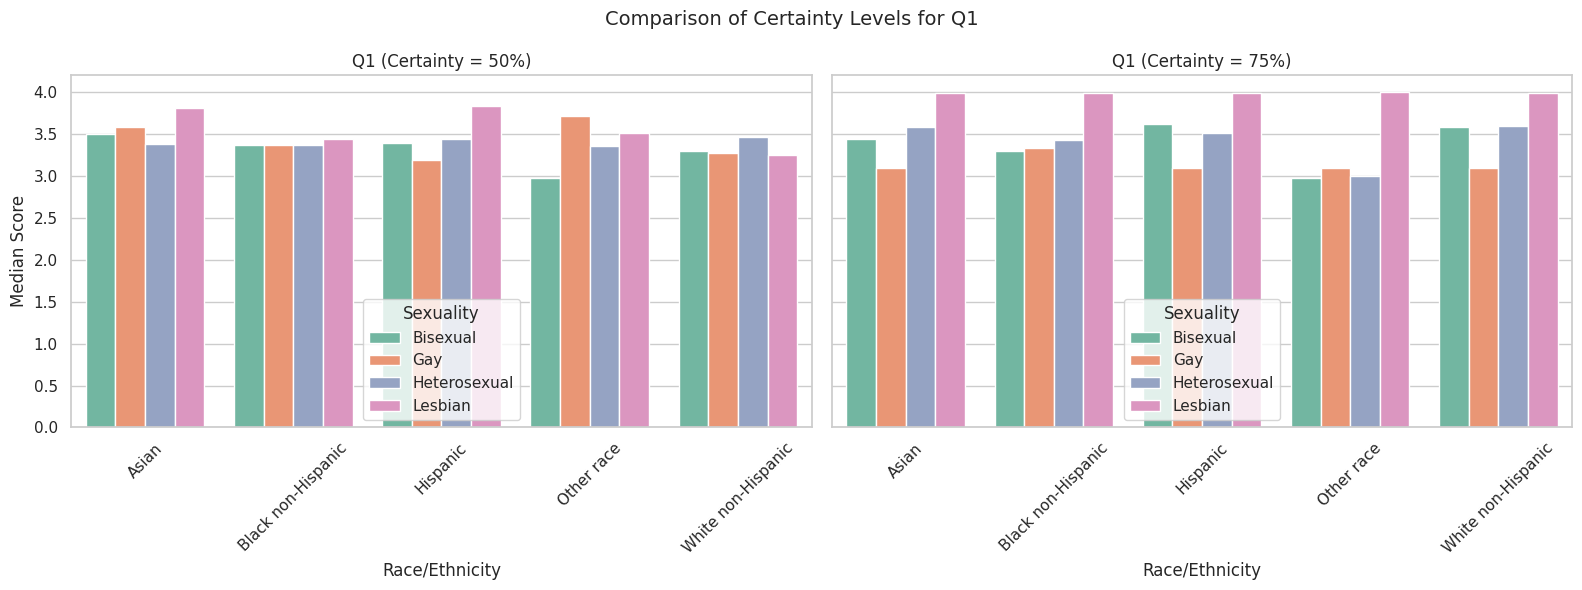

/tmp/ipython-input-1025736540.py:28: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(
/tmp/ipython-input-1025736540.py:43: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(


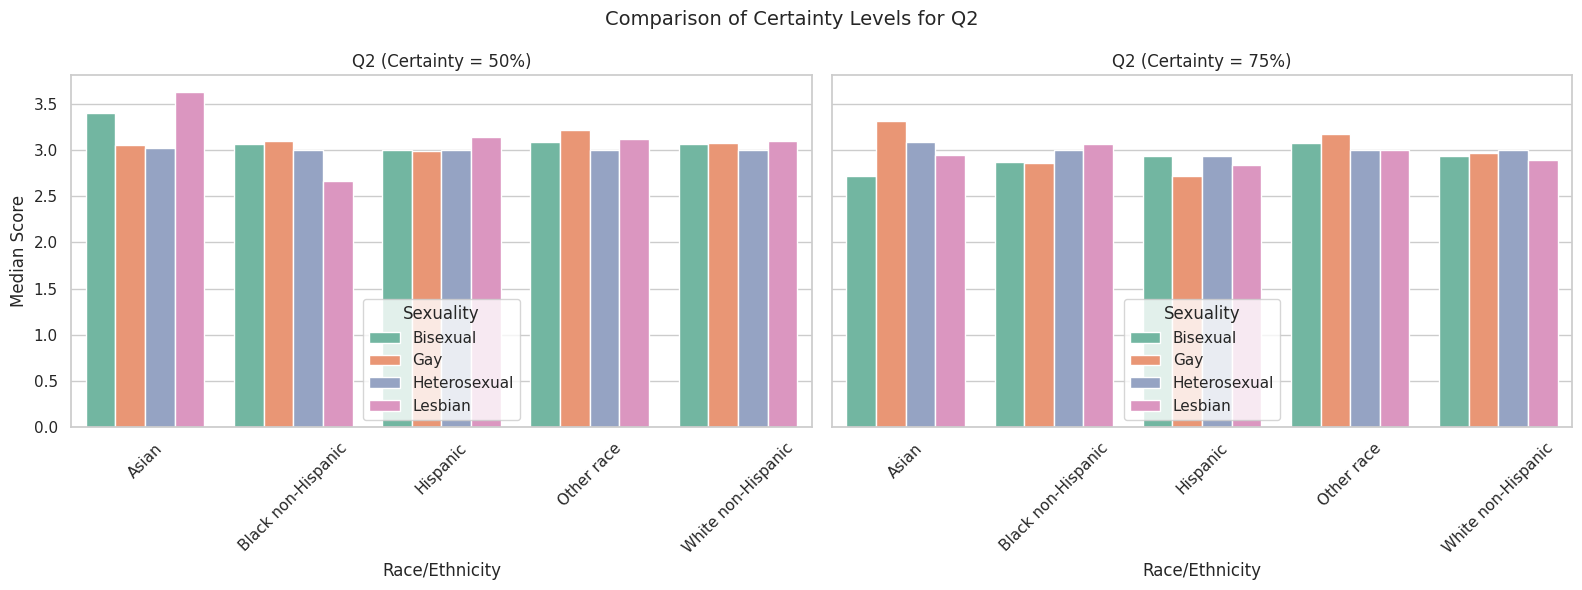

/tmp/ipython-input-1025736540.py:28: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(
/tmp/ipython-input-1025736540.py:43: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(


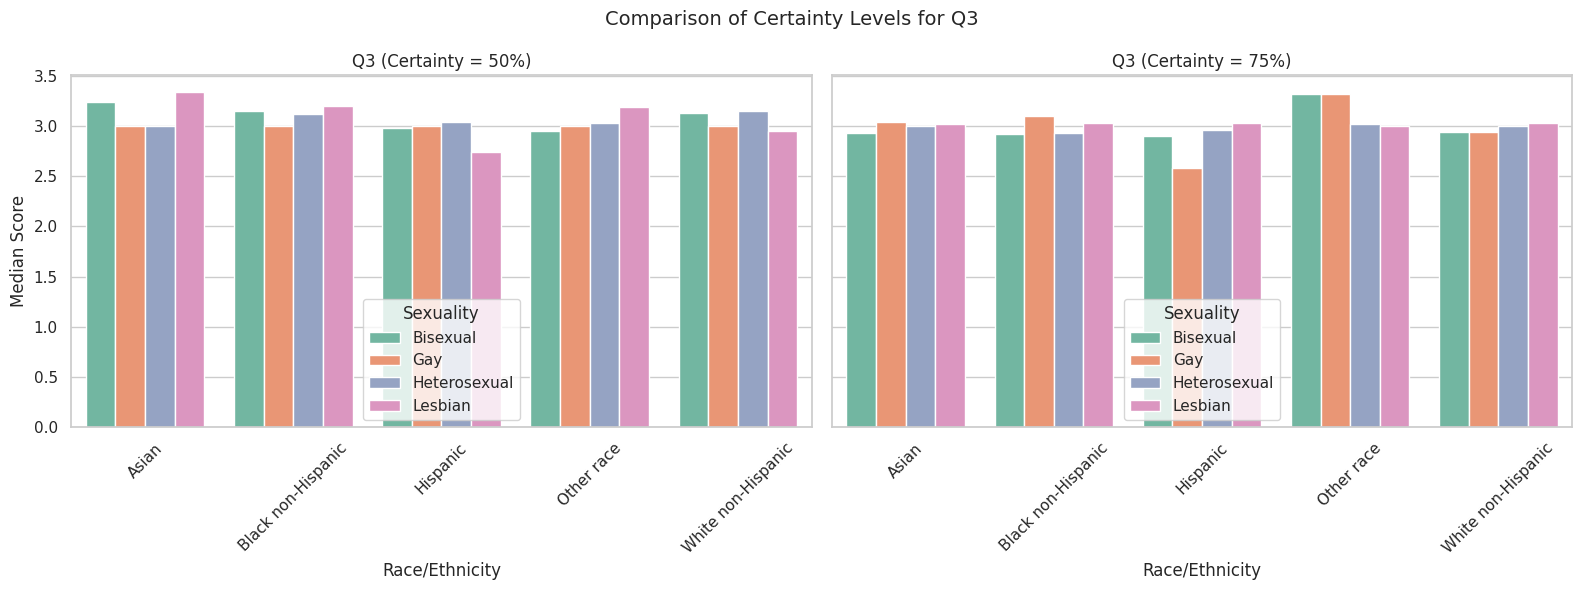

/tmp/ipython-input-1025736540.py:28: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(
/tmp/ipython-input-1025736540.py:43: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(


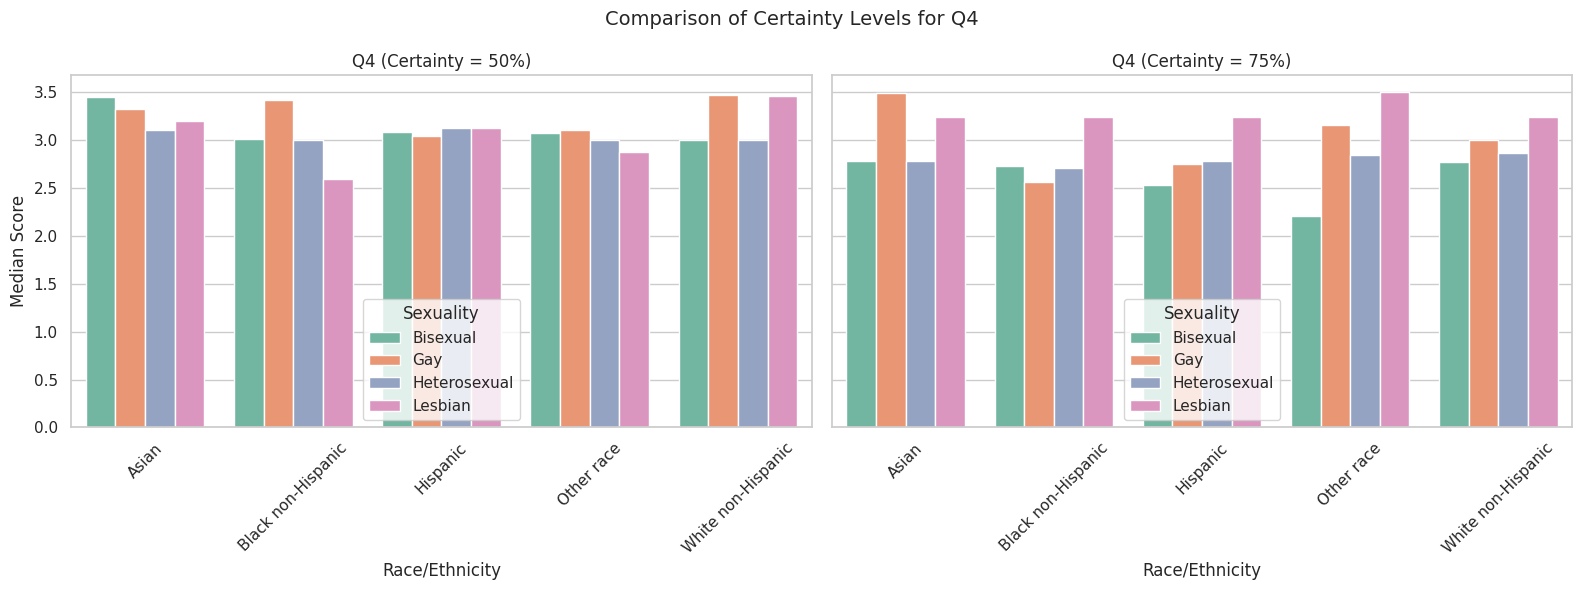

/tmp/ipython-input-1025736540.py:28: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(
/tmp/ipython-input-1025736540.py:43: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(


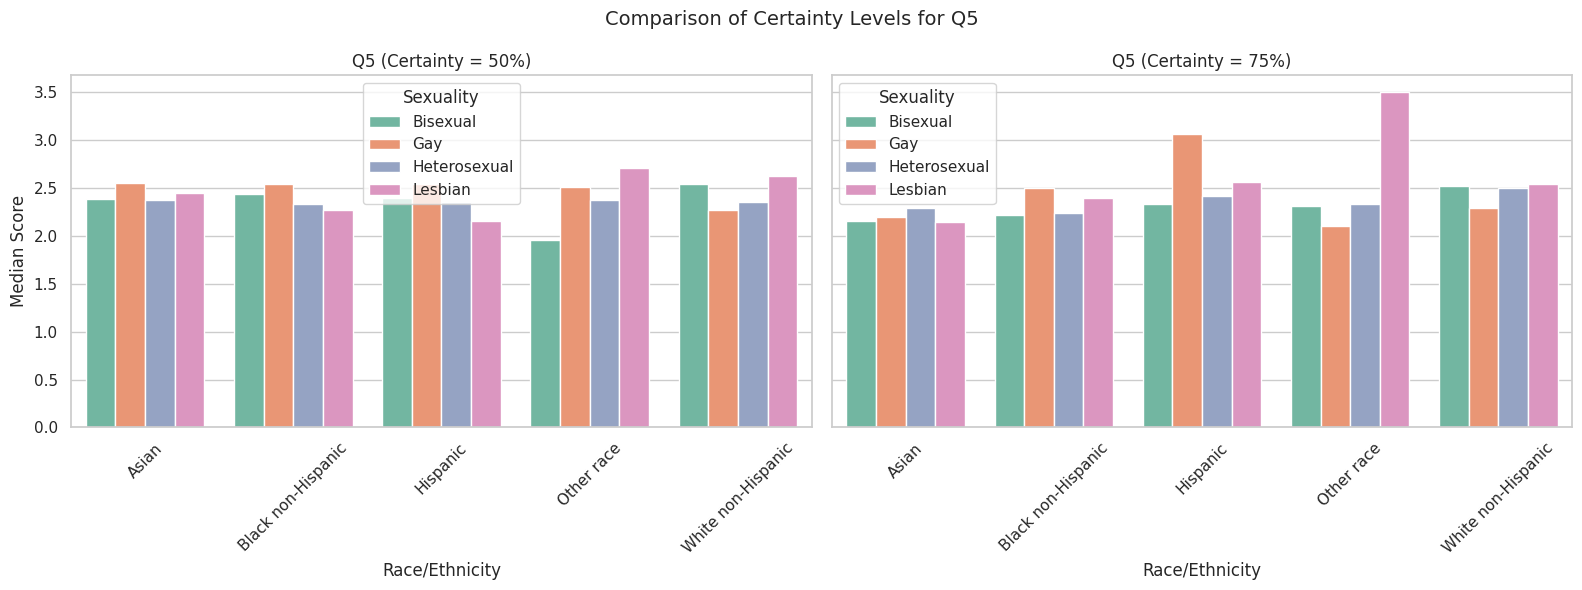

/tmp/ipython-input-1025736540.py:28: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(
/tmp/ipython-input-1025736540.py:43: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(


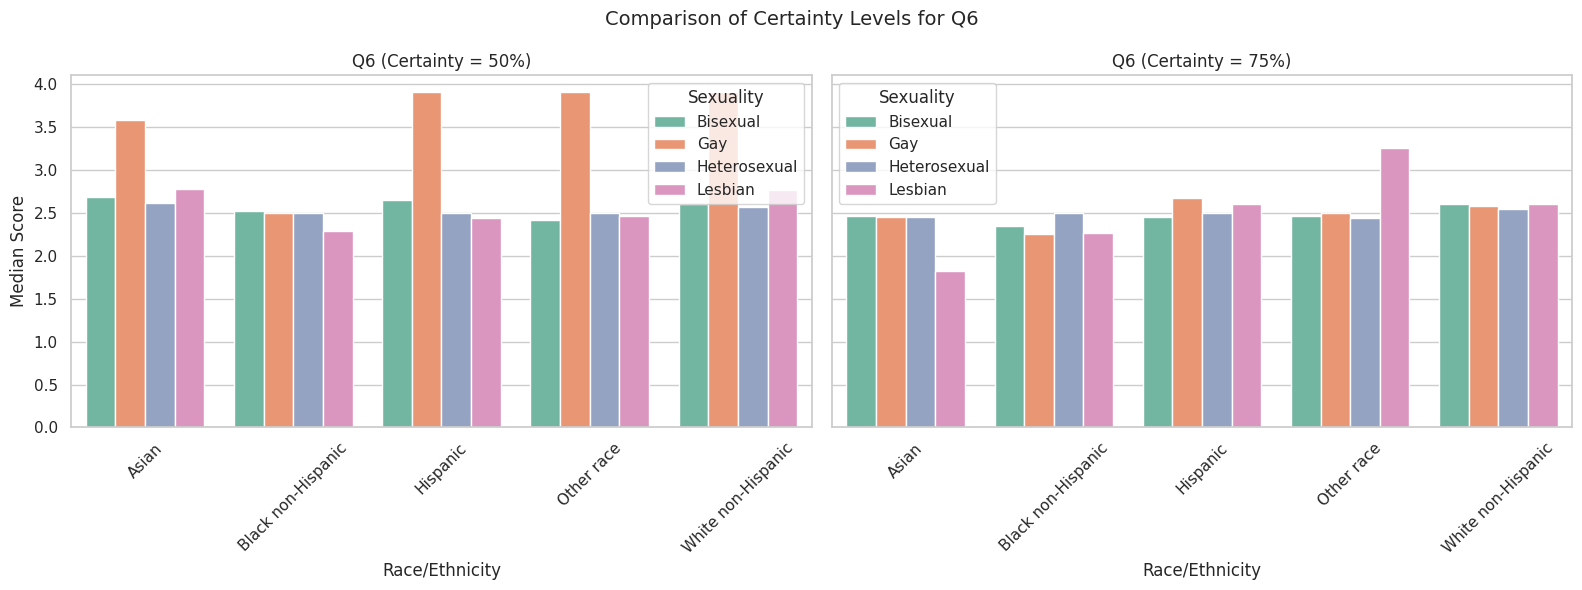

/tmp/ipython-input-1025736540.py:28: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(
/tmp/ipython-input-1025736540.py:43: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(


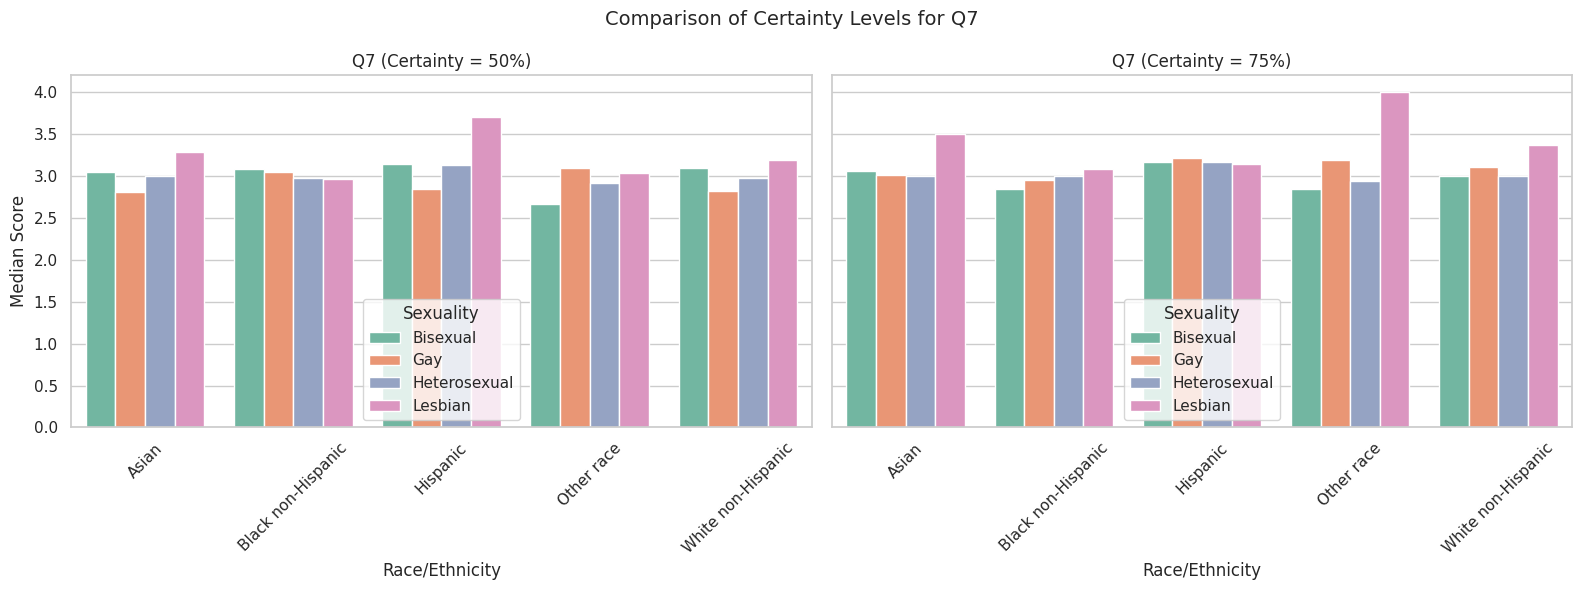

/tmp/ipython-input-1025736540.py:28: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(
/tmp/ipython-input-1025736540.py:43: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.barplot(


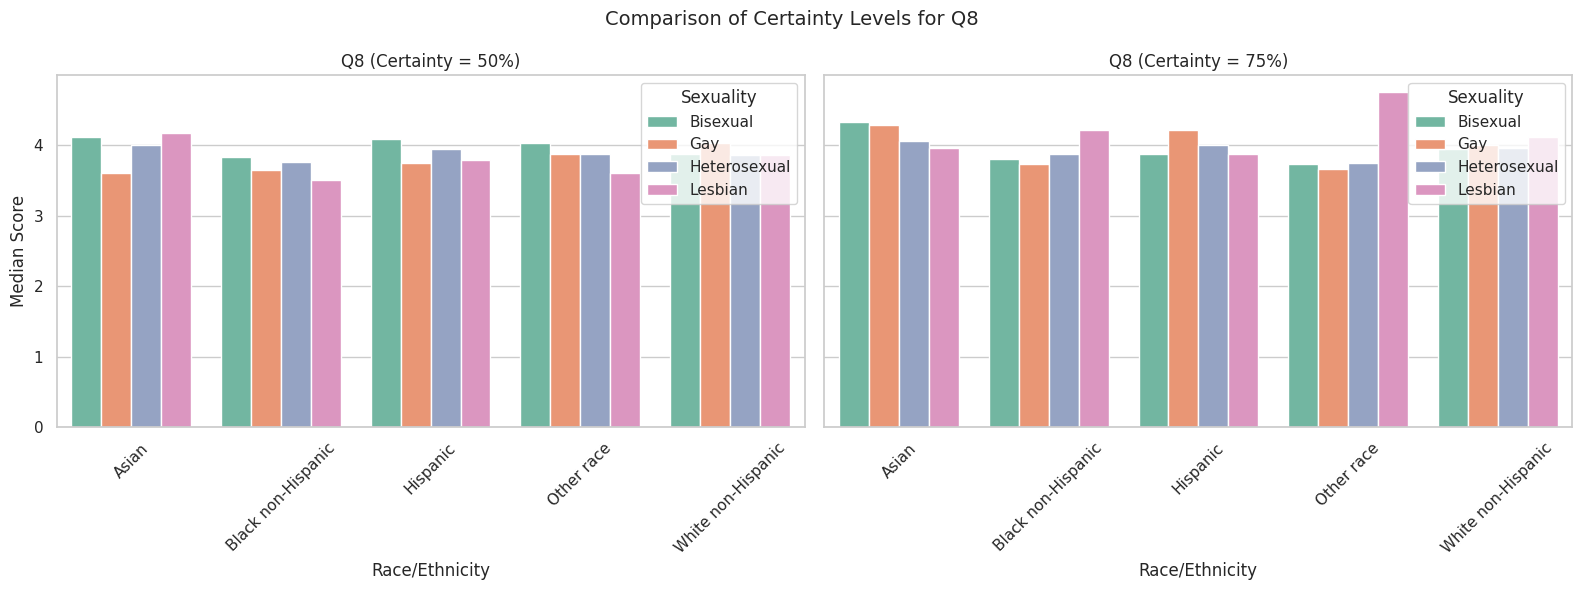

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

score_types = ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"]
palette = sns.color_palette("Set2")

for score_type in score_types:
    # Filter the dataframe for each certainty level
    df_50 = df_final[df_final['Certainty'] == 50]
    df_75 = df_final[df_final['Certainty'] == 75]

    # Group and calculate the median for each subgroup
    average_scores_50 = (
        df_50.groupby(['RACETHN', 'SEXUALITY'])[score_type]
        .median()
        .reset_index()
    )
    average_scores_75 = (
        df_75.groupby(['RACETHN', 'SEXUALITY'])[score_type]
        .median()
        .reset_index()
    )

    # Create side-by-side subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

    # Left subplot: Certainty = 50
    sns.barplot(
        x='RACETHN',
        y=score_type,
        hue='SEXUALITY',
        data=average_scores_50,
        palette=palette,
        ax=axes[0]
    )
    axes[0].set_title(f'{score_type} (Certainty = 50%)')
    axes[0].set_xlabel('Race/Ethnicity')
    axes[0].set_ylabel('Median Score')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].legend(title='Sexuality')

    # Right subplot: Certainty = 75
    sns.barplot(
        x='RACETHN',
        y=score_type,
        hue='SEXUALITY',
        data=average_scores_75,
        palette=palette,
        ax=axes[1]
    )
    axes[1].set_title(f'{score_type} (Certainty = 75%)')
    axes[1].set_xlabel('Race/Ethnicity')
    axes[1].set_ylabel('Median Score')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].legend(title='Sexuality')

    # Overall figure title
    plt.suptitle(f'Comparison of Certainty Levels for {score_type}', fontsize=14)

    plt.tight_layout()
    plt.show()

Does certainty of 50 vs 75 produce significantly diff harm scores? In almost all cases, it does.

In [31]:
import itertools
from scipy import stats

score_types = ["Q1", "Q2", "Q3", "Q4", "Q5", "Q6", "Q7", "Q8"]

for score in score_types:
    # Separate data for 50% vs 75% certainty
    data_50 = df_final[df_final['Certainty'] == 50][score].dropna()
    data_75 = df_final[df_final['Certainty'] == 75][score].dropna()

    # Only run a t-test if both groups have sufficient data
    if len(data_50) >= 2 and len(data_75) >= 2:
        t_stat, p_val = stats.ttest_ind(data_50, data_75, equal_var=False)
        print(f"{score} | t = {t_stat:.3f}, p = {p_val:.3e}")
    else:
        print(f"{score} | Not enough data for t-test.")

Q1 | t = -19.635, p = 5.136e-85
Q2 | t = 5.934, p = 3.013e-09
Q3 | t = 15.001, p = 1.372e-50
Q4 | t = 30.900, p = 8.435e-205
Q5 | t = -0.506, p = 6.130e-01
Q6 | t = 12.462, p = 1.627e-35
Q7 | t = 0.374, p = 7.083e-01
Q8 | t = -5.371, p = 7.911e-08
